<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) and [Dennis G. Wilson](https://personnel.isae-supaero.fr/dennis-wilson) | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;"> Deep Learning</div>

This class supposes a basic knowledge of Artificial Neural Networks, Backpropagation and Stochastic Gradient Descent (as introduced in the previous class). If you want an in-depth refresher on linear algebra specific to deep learning, [these notebooks](https://github.com/hadrienj/deepLearningBook-Notes) are well-done.

0. [Preparation](#sec0)
1. [Dataset: Fashion-MNIST](#sec1)
2. [ANNs in Layers](#sec2)
3. [Backpropagation and training](#sec3)
4. [Activation Functions](#sec4)
5. [Convolutional Neural Networks](#sec5)
6. [Overfitting](#sec6)
7. [Improving Optimization](#sec7)


# <a id="sec0">0. Preparation</a>

In this notebook, we'll be using `torch`, `torchvision`, and `ignite`. Please refer to the [PyTorch](https://pytorch.org/get-started/locally/) website for installation instructions. We'll also be using the packages `sklearn`, `numpy`, and `matplotlib`. To make the notebook into slides, I'm using [`rise`](https://github.com/damianavila/RISE) which you can also install. Note that this notebook is fairly compute intensive and might be better [run in Google Colab.](https://colab.research.google.com/github/SupaeroDataScience/deep-learning/blob/main/deep/Deep%20Learning.ipynb)

<div class="alert alert-success">
Exercise 1:
Install the necessary packages and verify that everything is working by importing everything.
</div>

In [2]:
# !pip install torch torchvision pytorch-ignite

In [1]:
import torch
import torchvision
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# <a id="sec1">1. Dataset: Fashion-MNIST</a>

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits but is more complex.

<img src="img/fashion-mnist-small.png">

In [2]:
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

PyTorch comes with this dataset by default, but we need to download it. We'll then make dataloaders which lazily iterate through the datasets. We'll use a training set and a validation set and greatly reduce their sizes to make this notebook run in a reasonable time.

In [3]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000))
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

The test data should also be downloaded. We'll use it at the very end of this notebook to test our model.

In [4]:
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

<div class="alert alert-success">
Exercise 2:
Download the Fashion-MNIST dataset and run the following code.
    
+ Why are there 4 images in our list?
+ Why does the list of images change every time we run the code?

</div>

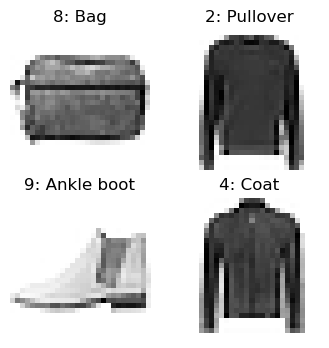

In [5]:
# get the first batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.figure(figsize=(4,4))
for i in range(len(images)):
    l = labels[i].numpy()
    plt.subplot(2, 2, i+1)
    plt.title('%d: %s' % (l, labels_text[l]))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')

In [6]:
ma_list = (i for i in range(10))
iter(ma_list)
next(ma_list)
next(ma_list)
next(ma_list)
next(ma_list)
next(ma_list)
next(ma_list)
next(ma_list)


6

For the rest of today, we'll focus on creating a deep neural network that accurately classifies these images. This will highlight one application of deep learning, image processing, which has been highly successful. In upcoming classes, we'll see other examples of deep learning (GANs, LSTMs) which have different architectures and training rules. However, the basic principles remain the same!

# <a id="sec2">2. ANNs in Layers</a>

Last class, we looked at individual neurons organized in networks like this:

<img src="img/nn_fc.png" width="60%">

These two hidden layers are called "Fully Connected layers" because every neuron of these layers is connected to every neuron of the previous layer.

In PyTorch, Fully Connected layers are represented with the `torch.nn.Linear` function. The documentation is [here](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20linear#torch.nn.Linear) or we can ask Jupyter:

In [9]:
help(torch.nn.Linear)

Help on class Linear in module torch.nn.modules.linear:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math

Let's make a single fully connected layer:

In [7]:
from torch import nn
fc = nn.Linear(784, 10)

Let's use this layer as a network and construct a forward pass function. Our image data is 28 by 28, but we want it to match the layer dimensions. We'll transform the image from 28 by 28 to 1 by 784, and then pass the image through our fully connected layer.

In [8]:
def forward(x): # x is the image
    x = x.view(-1, 28 * 28) # Transforms from (1, 28, 28) to (1, 784)
    x = fc(x) # Goes through fully connected layer
    return x # Output, 10 neurons

We'll take the maximum output as our label prediction. Let's see how this layer does - remember we haven't trained it, it's completely random.

In [9]:
for batch in range(3):
    images, labels = next(dataiter)
    for i in range(len(images)):
        outputs = forward(images[i])
        h = np.argmax(outputs.detach().numpy())
        y = labels[i]
        print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 7 Sneaker, Predicted: 8 Bag
True: 7 Sneaker, Predicted: 8 Bag
True: 6 Shirt, Predicted: 0 T-shirt/top
True: 4 Coat, Predicted: 4 Coat
True: 8 Bag, Predicted: 2 Pullover
True: 7 Sneaker, Predicted: 3 Dress
True: 6 Shirt, Predicted: 8 Bag
True: 0 T-shirt/top, Predicted: 8 Bag
True: 2 Pullover, Predicted: 0 T-shirt/top
True: 3 Dress, Predicted: 8 Bag
True: 4 Coat, Predicted: 0 T-shirt/top
True: 9 Ankle boot, Predicted: 8 Bag


Let's double check that our fully connected layer is simply doing $$y = w^T x + b$$

In [10]:
a = (np.matmul(images[1].view(-1, 784), np.transpose(fc.weight.detach().numpy())) + fc.bias)[0].detach().numpy()
b = forward(images[1]).detach().numpy() 
# detach = sortir du noeud de calcul 

print('Numpy:\n', a)
print('PyTorch:\n', b)

Numpy:
 [ 0.3968173   0.51894057 -0.12525013  0.13433173  0.32989824  0.25898218
  0.17008573 -0.15237759  0.8671519  -0.3302679 ]
PyTorch:
 [[ 0.39681745  0.5189407  -0.12525028  0.13433182  0.32989794  0.25898224
   0.17008574 -0.15237746  0.86715186 -0.33026773]]


In [14]:
print(a == b, 'difference: ', np.sum((a-b)**2))

[[ True False False False False False False False False False]] difference:  1.075251e-13


We might have some slight errors due to floating point representation differences between PyTorch and numpy, but the calculation is the same!

<div class="alert alert-success">
Exercise 3:
    
1. The following code produces different predictions every time. Why? Change it so that it always predicts the same response.
2. Change the forward pass function to a network with the following fully connected layers: (784, 128), (128, 10). Test this network with random weights on some images.
    
</div>

In [11]:
def forward(x):
    x = x.view(-1, 28 * 28)
    x = nn.Linear(784,10)(x)
    return x

for i in range(len(images)):
    outputs = forward(images[i])
    h = np.argmax(outputs.detach().numpy())
    y = labels[i]
    print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 2 Pullover, Predicted: 1 Trouser
True: 3 Dress, Predicted: 6 Shirt
True: 4 Coat, Predicted: 4 Coat
True: 9 Ankle boot, Predicted: 1 Trouser


In [12]:
# %load solutions/ex3_1.py
fc1 = nn.Linear(784, 128)
fc2 = nn.Linear(128, 10)


In [13]:
# %load solutions/ex3_2.py
def forward(x):
    x = x.view(-1, 28 * 28)
    x = fc1(x)
    x = fc2(x)
    return x

for i in range(len(images)):
    outputs = forward(images[i])
    h = np.argmax(outputs.detach().numpy())
    y = labels[i]
    print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))


True: 2 Pullover, Predicted: 0 T-shirt/top
True: 3 Dress, Predicted: 1 Trouser
True: 4 Coat, Predicted: 8 Bag
True: 9 Ankle boot, Predicted: 3 Dress


We'll formalize our neural network functions in a `torch.nn.Module` class which creates the layers when initialized and then calculates the forward pass of the network with the function `forward(x)`.

In [14]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
net = SimpleNet()

Now that we have our network, we're ready to train it.

# <a id="sec3">3. Backpropagation and training</a>

So far, the way we've been using `torch` has been almost equivalent to `numpy`, and we've been calling `detach().numpy()` on `torch` objects to convert them to numpy arrays. We haven't yet taken advantage of the main benefit of `torch`: automatic differentiation. Let's look at that and see how it helps us train our neural network.

First, a bit of vocabulary. The objects we're working with, neural network weights and biases, are called `tensors`. 
<img src="img/tensor.png" width="50%">
<br>A `tensor` is a generic term for a linear mapping of any linear mapping from one algeabraic object to another. A scalar is a single value, a vector a 1D object of values, a matrix a 2D object, and a tensor is an N-dimension object (scalars, vectors, and matrices are also tensors). In deep learning frameworks, tensors are the core computational object. We store all values in tensors and link them in computational graphs.

A torch tensor looks very much like a numpy object. We can compare a 2D torch tensor and a numpy matrix:

In [16]:
a = np.ones((2, 2))
b = torch.ones(2, 2)
print('Numpy: ', a)
print('Torch: ', b)
np.all(b.numpy() == a)

Numpy:  [[1. 1.]
 [1. 1.]]
Torch:  tensor([[1., 1.],
        [1., 1.]])


True

However, we can ask torch to keep track of the gradient of a tensor. As this tensor is used to compute other tensors, this will create a computational graph.

In [18]:
x = torch.ones(2, 2, requires_grad=True) # garder un espace mémoire pour stocker les gradients dans le graph de calcul
print('x: ', x)
y = (3 * x * x).mean()
print('y: ', y)
y.backward() # 
print('dy/dx: ', x.grad)

x:  tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y:  tensor(3., grad_fn=<MeanBackward0>)
dy/dx:  tensor([[1.5000, 1.5000],
        [1.5000, 1.5000]])


The gradient definition in `y` depends on the calculation of `x` and allows us to calculate `dy/dx` by calling `backward()`. This is known as automatic differentiation, as the gradients at each step in the computation are automatically calculated. If you want to go further in detail about this, check out the [autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

Let's use automatic differentiation to calculate the gradients of our neural network parameters. This will automatically perform backpropogation using the gradient definition at each function in our network.

In [19]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
onehot = torch.nn.functional.one_hot(labels, num_classes=10).float()
labels, onehot

(tensor([4, 2, 2, 9]),
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

`images` contains our batch of input, so calling `net` on it will perform a forward pass through the network. We'll then compare this to the onehot encoded label and compute the Mean Squared Error.

In [20]:
net = SimpleNet()
outputs = net(images)
print('Outputs ', outputs)
loss = torch.sum((outputs - onehot) ** 2, 1).mean()
print('Loss ', loss)

Outputs  tensor([[-0.3837, -0.1025, -0.1676,  0.1593, -0.0713, -0.3452, -0.3849, -0.2577,
         -0.0282, -0.1198],
        [-0.3007, -0.0368, -0.0278,  0.1754, -0.1820, -0.4643, -0.3779, -0.1995,
          0.0787, -0.1209],
        [-0.3722, -0.0659, -0.0807,  0.2556,  0.1481, -0.3131, -0.2925, -0.6189,
          0.1317, -0.1842],
        [-0.0066,  0.0491, -0.3125,  0.1788, -0.2241, -0.2488, -0.6965, -0.1594,
          0.4410,  0.0643]], grad_fn=<AddmmBackward0>)
Loss  tensor(1.7949, grad_fn=<MeanBackward0>)


Now that we've calculated the error, we can backpropagate it using `backward()`. We first set all the gradients to zero, and then we'll observe how the gradients of the second layer's bias change.

In [21]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('fc2.bias.grad before backward')
print(net.fc2.bias.grad)

loss.backward()

print('fc2.bias.grad after backward')
print(net.fc2.bias.grad)

fc2.bias.grad before backward
None
fc2.bias.grad after backward
tensor([-0.5316, -0.0781, -1.2943,  0.3845, -0.6646, -0.6857, -0.8759, -0.6177,
         0.3116, -0.6803])


We can use this gradient calculation to update the neural network weights:
$$w_{ij} \leftarrow w_{ij} - \alpha \left(f_\theta(x) - y\right) \delta_j x_{ij}$$

In [22]:
print('fc2.bias before training')
print(net.fc2.bias.data)

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

print('fc2.bias after training')
print(net.fc2.bias.data)

fc2.bias before training
tensor([-0.0080,  0.0651,  0.0458,  0.0263, -0.0027, -0.0858, -0.0548,  0.0742,
         0.0740, -0.0260])
fc2.bias after training
tensor([-0.0027,  0.0659,  0.0587,  0.0225,  0.0039, -0.0789, -0.0460,  0.0803,
         0.0709, -0.0192])


Torch provides loss functions and optimizers that we can use instead of writing our own. For now, we'll use the `torch.nn.CrossEntropyLoss` and `torch.optim.SGD` functions.

Just one last thing before we train on the full dataset: we're calculting the gradients at every batch, not at every data point. This is an expensive gradient calculation, so let's reduce the number of times we do it by increasing the batch size. This has the benefit of reducing overfitting by computing the gradient over a large sample of images.

In [23]:
def train(net):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

In [24]:
net = SimpleNet()
%time train_loss = train(net)
print(train_loss)

CPU times: user 27.8 ms, sys: 24.4 ms, total: 52.2 ms
Wall time: 1.13 s
43.95183777809143


To see how our network performs, we'll apply it to the validation set.

In [25]:
def get_valid_predictions(net):
    validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False)
    all_labels = np.array([])
    predictions = np.array([])
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.numpy())
            predictions = np.append(predictions, predicted.numpy())
    return all_labels, predictions

In [26]:
y_valid, predictions = get_valid_predictions(net)

In [27]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy: ', accuracy_score(predictions, y_valid))
print(classification_report(predictions, y_valid, target_names=labels_text))

Accuracy:  0.416
              precision    recall  f1-score   support

 T-shirt/top       0.41      0.35      0.38       102
     Trouser       0.31      0.41      0.35        80
    Pullover       0.42      0.39      0.41       115
       Dress       0.62      0.36      0.45       185
        Coat       0.06      0.31      0.10        16
      Sandal       0.33      0.31      0.32       113
       Shirt       0.14      0.38      0.20        39
     Sneaker       0.92      0.38      0.53       248
         Bag       0.24      0.92      0.38        25
  Ankle boot       0.71      0.84      0.77        77

    accuracy                           0.42      1000
   macro avg       0.42      0.47      0.39      1000
weighted avg       0.56      0.42      0.44      1000



# <a id="sec4">4. Activation Functions</a>

So far, our network is a chain of $$ Y = w^T x+b $$ However, in the last class, the neurons we modeled used sigmoid functions: $$ Y = \sigma(w^T x+b) $$ Let's apply this to our current network and see how it changes training. Torch has two ways to do this: define a `torch.nn.Sigmoid` layer or apply the `torch.sigmoid` function. We'll use the functional method.

In [28]:
class SigmoidNet(nn.Module):
    def __init__(self):
        super(SigmoidNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

net = SigmoidNet()

In [29]:
total_loss = train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))

Accuracy:  0.096


## Rectified Linear Units (ReLU)

We'll now look at a different activation function, the ReLU. Remember the shape of the sigmoid activation function?

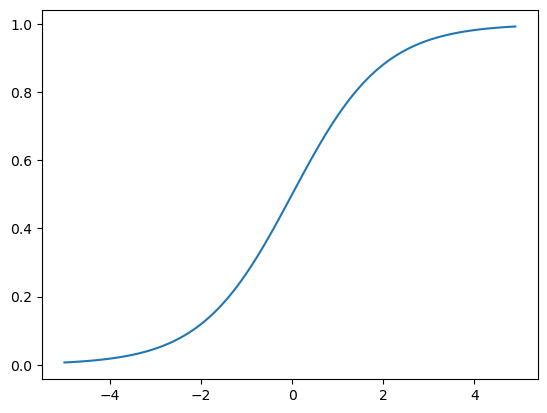

In [30]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));

Let's plot the gradient of this function.

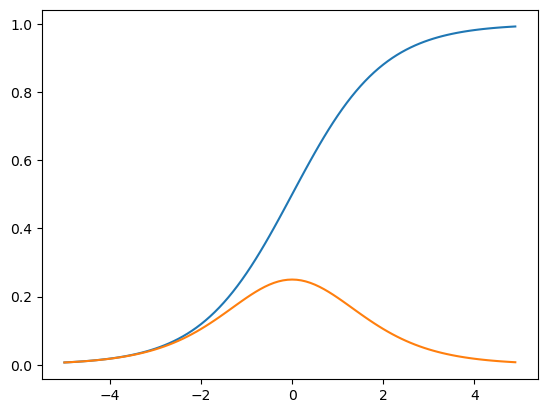

In [31]:
def sigmoid_der(x):
    y = sigmoid(x)
    return y*(1.-y)

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));
plt.plot(XX,sigmoid_der(XX));

Do you remember that during backpropagation, the $\delta_j$ were recursively obtained by:
$$\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}$$

This poses a major problem when the networks become deeper: at each layer, we multiply our gradients by $\sigma'(y_j)$ which is much smaller than 1. So the gradient we want to back-propagate shrinks to zero and all our weight updates become zero.

This is called the **vanishing gradient** problem.

To avoid this problem, we introduce a new type of activation function: the Rectified Linear Unit (ReLU).
$$\sigma(y) = \max\{0,y\}$$

The key property of this function is that its derivative is either zero or one.

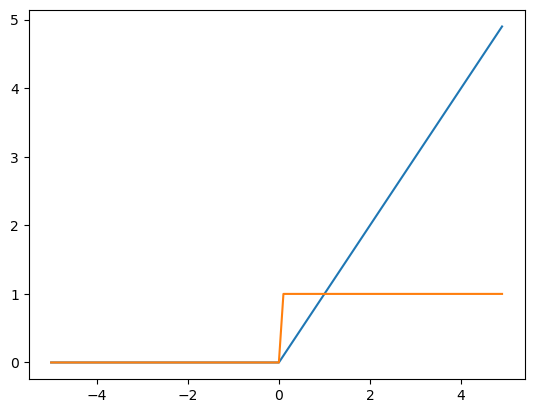

In [33]:
def relu(x):
    return np.maximum(0.,x)
def relu_der(x):
    return relu(x) > 0

plt.plot(XX,relu(XX));
plt.plot(XX,relu_der(XX));

**Caveat of using ReLU activation functions**

Although they allow us to train deep networks, ReLU functions have their downsides.
- Unbounded values: the output of a layer is not bounded anymore, causing possible divergence.
- Dying ReLU neurons: the backpropagation of gradients can push the input weigths towards values such that $\sigma(y)=0$ all the time. Then all future backpropagations will leave these weights unchanged: the neuron is dead.

Some advanced methods can compensate these weaknesses but are out of the scope of this introduction.

In torch, the ReLU activation function is either a layer `torch.nn.ReLU` or a function in `torch.nn.functional.relu`.

<div class="alert alert-success">
Exercise 5: Change the activation functions in your network. Experiment with different layer sizes and activations to get a higher accuracy.
</div>

In [35]:
# %load solutions/ex5.py
import torch.nn.functional as F

class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = ReLUNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))


Accuracy:  0.377


# <a id="sec5">5. Convolutional Neural Networks</a>

The main factor which makes deep learning so useful for computer vision is the use of convolutions. Convolutional networks exploit the fact that the data is actually an image in the learning while decreasing the number of weights in the network. To do this, they define **convolution filters** that brush across the image. Such a filter defines a so-called **feature map** that shares the weights of the filter. The result of applying a feature map on an image is a new image of lower resolution, where each pixel is the result of the convolution of the filter with a set of pixels from the input image, as illustrated on the figure below. The Stanford class [CS231n](http://cs231n.github.io/convolutional-networks/) also has an excellent demo.

<img src="img/convnet.gif" width="700px">

In [43]:
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]

    return output

In [44]:
rng = np.random.default_rng()
data = rng.integers(-5, 5, (1, 3, 3))
conv_W = np.array([[np.identity(2)]]) #np.ones((1, 1, 2, 2))
conv_b = np.zeros(1)
output = forward_convolution(conv_W, conv_b, data)
print("Input:\n", data)
print("Filter:\n", conv_W)
print("Bias:", conv_b)
print("Output:\n", output)

Input:
 [[[-3 -2  3]
  [-2 -3 -3]
  [ 3  3 -3]]]
Filter:
 [[[[1. 0.]
   [0. 1.]]]]
Bias: [0.]
Output:
 [[[-6. -5.]
  [ 1. -6.]]]


Convolutional layers extract important features from previous layers, transforming the image space into a feature space where each block of neurons corresponds to a feature set rather than a group of pixels. To aggregate these features, select the most important ones, and reduce the dimensionality of our network, we'll use the **pooling** operator. Pooling is the operation of down-sampling the image by grouping together certain pixels. The most common pooling operation takes the maximum value over a certain window. Max pooling has been shown to better separate features which are rare in the data.

Boureau, Y-Lan, Jean Ponce, and Yann LeCun. "A theoretical analysis of feature pooling in visual recognition." Proceedings of the 27th international conference on machine learning (ICML-10). 2010. [pdf](https://www.di.ens.fr/willow/pdfs/icml2010b.pdf)

<img src="img/maxpool.png">

One of the advantages of convolution is translational invariance: a feature can appear in different parts of an image, and the network will still detect it. Here's a simple example:

<img src="img/invariance.png">

When defining a convolutional layer, we define the number of channels, where a channel is one slice of neurons. Our input image has one channel - the dimensions are 28 by 28 by 1. A color image has three channels, red green and blue. Using convolution, we'll convert our image of 28 by 28 by 1 into a number of different channels, which we call feature maps. The other parameter we define is the size of the kernel - how large is the filter we're passing over the previous layer. 

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`

The options of stride, padding, dilation, and groups are further explained in the [documentation](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20conv2d#torch.nn.Conv2d). [This page](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) shows an illustration of these different options.

In [45]:
m = nn.Conv2d(1, 1, 2, stride=1)
m.weight = torch.nn.Parameter(torch.tensor(conv_W, dtype=torch.float))
m.bias = torch.nn.Parameter(torch.tensor(conv_b, dtype=torch.float))
input = torch.tensor(np.array([data]), dtype=torch.float)
output = m(input)
print("Input:", input)
print("Weight:", m.weight)
print("Bias:", m.bias)
print("Output:", output)

Input: tensor([[[[-3., -2.,  3.],
          [-2., -3., -3.],
          [ 3.,  3., -3.]]]])
Weight: Parameter containing:
tensor([[[[1., 0.],
          [0., 1.]]]], requires_grad=True)
Bias: Parameter containing:
tensor([0.], requires_grad=True)
Output: tensor([[[[-6., -5.],
          [ 1., -6.]]]], grad_fn=<ConvolutionBackward0>)


This creates the difficult question of how large is our convolutional layer, in terms of dimensions? Let's assume a layer with the following:

+ batch size $N$
+ input layer size $H_{in}$ by $W_{in}$
+ $C_{in}$ input channels
+ $C_{out}$ output channels
+ Kernel size $K$, assuming 2D for now

That is to say, the previous layer's size is $(N, C_{in}, H_{in}, W_{in})$. For our image input layer, this is $(512, 1, 28, 28)$. We want to calculate the size of the convolutional layer, $(N, C_{out}, H_{out}, W_{out})$. 

This size depends on our kernel size and the other convolutional parameters like stride and padding:

$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0] \times (K_0 - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
 
$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]\times (K_1 - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

Assuming the torch defaults of `stride=1, padding=0, dilation=1`, this simplifies to:

$$H_{out} = \left\lfloor H_{in} - K_0 + 1\right\rfloor$$
 
$$W_{out} = \left\lfloor W_{in} - K_1 + 1\right\rfloor$$

Note that this is straight from the [torch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

We'll use this calculation to make a small network with 8 feature maps and a kernel size of 4 by 4.

In [46]:
k = (4, 4)
h_in = 28
w_in = 28
c_in = 1
c_out = 8

In [47]:
output_size = c_out * (h_in - k[0] + 1) * (w_in - k[1] + 1)
print(output_size)

5000


In [48]:
class SmallConvNet(nn.Module):
    def __init__(self):
        super(SmallConvNet, self).__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, k)
        self.fc1 = nn.Linear(output_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

net = SmallConvNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))

Accuracy:  0.175


<div class="alert alert-success">
Exercise 6: Using the `torch.nn.Conv2d` and `torch.nn.MaxPool2d` layer functions (or `torch.nn.functional.max_pool2d`), define and test the following network:
    
- Input layer: images of size $28\times 28$ with a single channel
- Convolutional layer of 32 feature maps with $3\times 3$ filters
- Max pooling layer by blocks of size $2 \times 2$
- Convolutional layer of 64 feature maps with $3\times 3$ filters
- Max pooling layer by blocks of size $2 \times 2$
- Fully connected layer with 128 ReLU neurons
- Fully connected output layer with 10 ReLU neurons
</div>

In [50]:
# %load solutions/ex6.py
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.relu(x)
        return output

net = ConvNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))


Accuracy:  0.283


<div class="alert alert-info">
    <h3>Discussion</h3>
    
We previously defined backpropagation for feed-forward networks which used the gradient of the weighted sum and neural activation function. Can backpropagation still work with these two layer types, convolution and pooling? How? What requirement is there for the operators performed by each layer?
</div>

# <a id="sec6">6. Overfitting</a>

So far, we've been training on just one pass through the data, called an "epoch". In deep learning, networks are trained over multiple epochs, either a fixed amount or until a convergence metric is met. As we will see, this can lead to overfitting. We'll train for 30 epochs and watch the validation loss over training.

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()

def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    train_history = []
    valid_history = []
    for epoch in range(30):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
    return train_history, valid_history

In [ ]:
net = SimpleNet()
train_history, valid_history = train(net)

In [ ]:
def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()
    
plot_train_val(train_history, valid_history)

As we see in the above plots, the validation accuracy might fluctuate or increase while minimizing the training loss. If the validation loss increases too much while the training loss decreases, we consider this **overfitting** to the training data. 

## Early Stopping

One of the ways to overcome overfitting is early stopping. We'll stop the training early based on increases to the validation loss. If the validation loss is higher than the current lowest validation lost for a certain number of epochs we'll stop the training. The number of epochs we wait is known as the `patience`.

In [ ]:
class EarlyStopping:
    
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: %d / %d' % (self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
def train(net, earlystopping=True):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    train_history = []
    valid_history = []
    if earlystopping:
        estop = EarlyStopping(patience=2)
    for epoch in range(30):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
        if earlystopping:
            estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet()
train_history, valid_history = train(net)
plot_train_val(train_history, valid_history)

## Dropout

Another way to prevent overfitting is by not training certain weights at a given update step, leading to greater generalization over the whole network. The classic formulation of this is dropout, where neuron activations are "dropped out" (set to zero) with probability *p*. This is as if, for a given update, only a subnetwork is trained: 
<img src="img/dropout_network.png">
Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The journal of machine learning research 15.1 (2014): 1929-1958.

Dropout has shown improvements for overfitting with many different architectures, although the specifics of where to use dropout in a network and what dropout rates to use ($p$) are still not well-defined.

<img src="img/dropout_results.png">

Torch uses spatial dropout, which is described here: https://arxiv.org/pdf/1411.4280.pdf

<div class="alert alert-success">
Exercise 7: Create a network that includes at least one dropout layer. How does Dropout influence the training?
</div>

In [ ]:
# %load solutions/ex7.py

# <a id="sec7">7. Improving Optimization</a>

Just to review, training a neural network is a function of maximizing some objective function $Q$; it is a process of optimization. $Q$ can be, for example, a MSE Loss function:
$$
Q_i(\theta) = (X(\theta, i) - h_i)^2\\
Q(\theta) = \frac{1}{n}\sum_{i=1}^n Q_i(\theta)
$$
So far, we've been using SGD for this optimization:

In [ ]:
net = SimpleNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In other words, we're doing our weight ($\theta$) update according to the following:

$$
\Delta \theta^{(t+1)} \leftarrow \alpha\Delta \theta^{(t)}-\eta\nabla Q_i (\theta^{(t)})\\
\theta^{(t+1)} \leftarrow \theta^{(t)} + \Delta \theta^{(t+1)}
$$

These two hyperparameters, learning rate ($\alpha$) and momentum ($\eta$), change how the neural network minimizes the loss and can have drastic impact on the learning.

<img src="img/sgd.gif" width="80%">

A popular optimizer is the Adaptive Moment Estimation ([Adam](https://arxiv.org/pdf/1412.6980.pdf)) optimizer. This optimizer takes into account the recent weight changes when making a new update:

$$
m_\theta^{(t+1)} \leftarrow \beta_1 m_\theta^{(t)} + (1-\beta_1) \nabla Q_i(\theta^{(t)})\\
v_\theta^{(t+1)} \leftarrow \beta_2 v_\theta^{(t)} + (1-\beta_2)(\nabla Q_i(\theta^{(t)}))^2\\
\hat{m}_\theta = \frac{m_\theta^{(t+1)}}{1-\beta_1^t}\\
\hat{v}_\theta = \frac{v_\theta^{(t+1)}}{1-\beta_2^t}\\
\theta^{(t+1)} \leftarrow \theta^{(t)} - \eta\frac{\hat{m}_\theta}{\sqrt{\hat{v}_\theta}+\epsilon}
$$

While this optimizer can often perform better than SGD, it introduces new hyperparameter choices: $\beta_1$ (update to $\hat{m}$), $\beta_2$ (update to $\hat{v}$), and $\epsilon$ (ratio between $\hat{m}$ and $\hat{v}$). Let's see the defaults for torch:

In [ ]:
help(torch.optim.Adam)

As with SGD, the choice of hyperparameters heavily affects the training.

<img src="img/adam.gif" width="80%">

<div class="alert alert-success">
Exercise 8: change the optimizer in our training method to Adam and train one of the networks we've defined.
</div>

In [ ]:
# %load solutions/ex8.py

In this notebook, our training code has gotten very long. Thankfully, `torch` comes with a high-level library [`ignite`](https://pytorch.org/ignite/) which allows us to easily train and including things like EarlyStopping and logging. That's out of the scope of the material for today, but please look at [this notebook](https://github.com/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb) before next class.

Some other libraries like `ignite`:
+ https://docs.fast.ai/
+ https://github.com/skorch-dev/skorch
+ https://github.com/williamFalcon/pytorch-lightning

# 8. Neural Architectures

So far, we've seen a number of different layer types, (Fully-connected, Convolutional, MaxPooling) activations (Sigmoid, ReLU, Softmax), and additional components like Dropout, which we include as a sort of "layer" in our
architecture. These and more are all the base components of neural networks which can be mixed and matched to create different neural architectures. Let's work our way through some historical milestones.

## 8.1 LeNet

<img src="img/lenet.png">

LeNet is often considered the first modern deep convolutional neural network.
    
LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.

## 8.2 AlexNet

<img src="img/alexnet.png">

AlexNet became well-known due to its performance on the ImageNet classification
benchmark.

Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.
    
https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

## 8.3 VGG (16)

<img src="img/vgg16.png">

The ImageNet benchmark and related competition continued to be a source of new
architectures in the 2010s with the VGG family of architectures also gaining
recognition for their performance. The impressive depth of these networks was
novel and built on advances in weight optimization.
    
Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." ICLR, 2015.

## 8.4 InceptionNet

<img src="img/inception.png">

While VGG went deeper, other networks started proposing parallel blocks of small
convolutions which allowed for better dimensionality reduction. The InceptionNet
is composed of these so-called "inception blocks".

Szegedy, Christian, et al. "Rethinking the inception architecture for computer vision." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py

## 8.5 GoogLeNet

<img src="img/googlenet.png">

GoogLeNet, named after LeNet, combined advances like inception blocks and the
deeper VGG architectures, beating VGG in 2014 by 7.32% to 6.67% on the ImageNet
benchmark.

Szegedy, Christian, et al. "Going deeper with convolutions." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

https://github.com/pytorch/vision/blob/master/torchvision/models/googlenet.py

## 8.6 ResNet

<img src="img/resnet.png">
<img src="img/resnet_vgg.png">

Residual Networks use skip or shortcut connections, unweighted identity
functions, to pass information from one part of the newtork to a later part.
These so-called "residual blocks" allow for independent functions to be learned
by a part of the network without needing to also pass a transformation of the
data down-stream.

He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

## 8.7 Differentiable Architecture Search

<img src="img/darts.png">

Neural Architecture Search, the automatic research for architectures, is growing
as a research field. Better networks than ResNet or VGG have been found with
these method for the CIFAR and ImageNet benchmarks.

Liu, Hanxiao, Karen Simonyan, and Yiming Yang. "DARTS: Differentiable
Architecture Search." International Conference on Learning
Representations. 2018. [pdf](https://arxiv.org/pdf/1806.09055.pdf)

## 8.8 NSGA-Net

<img src="img/nsganet.png" width="50%" height=auto>

Evolutionary algorithms are one popular approach to neural architecture search,
such as NSGA-Net. Important objectives in NAS are to increase model accuracy
while reducing complexity, measured by training time and number of parameters.

Lu, Zhichao, et al. "Nsga-net: neural architecture search using multi-objective
genetic algorithm." Proceedings of the Genetic and Evolutionary Computation
Conference. 2019. [code](https://github.com/ianwhale/nsga-net)

<div class="alert alert-success">
Exercise 9 (at home): Look at one of the torchvision implementations of models and the reference paper to understand how the torch version is implemented. Train a network of your choice on CIFAR10 using ignite.
</div>